In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:

# import data
iris = sns.load_dataset("iris")

# organize data
data = torch.tensor(iris[iris.columns[0:4]].values, dtype=torch.float32)
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species == "setosa"] = 0
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

# making train and test sets using sklearn
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2
)
# convert them into pytorch datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
# checking shapes
for data, labels in train_loader:
    print(f"train data: {data.shape} train labels: {labels.shape}")
for data, labels in test_loader:
    print(f"test data: {data.shape} test labels: {labels.shape}")


train data: torch.Size([12, 4]) train labels: torch.Size([12])
train data: torch.Size([12, 4]) train labels: torch.Size([12])
train data: torch.Size([12, 4]) train labels: torch.Size([12])
train data: torch.Size([12, 4]) train labels: torch.Size([12])
train data: torch.Size([12, 4]) train labels: torch.Size([12])
train data: torch.Size([12, 4]) train labels: torch.Size([12])
train data: torch.Size([12, 4]) train labels: torch.Size([12])
train data: torch.Size([12, 4]) train labels: torch.Size([12])
train data: torch.Size([12, 4]) train labels: torch.Size([12])
train data: torch.Size([12, 4]) train labels: torch.Size([12])
test data: torch.Size([30, 4]) test labels: torch.Size([30])


In [4]:
def createModel(L2Lambda):
    # ANN and parameters
    ANNiris = nn.Sequential(
        nn.Linear(4, 64),  # input layer
        nn.ReLU(),  # activation function
        nn.Linear(64, 64),  # hidden layer
        nn.ReLU(),  # activation function
        nn.Linear(64, 3),  # output layer
    )
    lossFun = nn.CrossEntropyLoss()  # loss function includes softmax as well
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.01, weight_decay=L2Lambda)
    return ANNiris, lossFun, optimizer

In [5]:
def training(ANNiris, lossFun, optimizer, epochs=500):
    # training
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)

    for epoch in range(epochs):
        ANNiris.train()  # train mode
        # train in batches
        batchacc = []
        for data, labels in train_loader:
            # forward pass
            output = ANNiris(data)

            # compute loss
            loss = lossFun(output, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy
            predLabel = torch.argmax(output, axis=1)
            batchacc.append(torch.mean((predLabel == labels).float()) * 100)

        # train accuracy
        train_acc[epoch] = np.mean(batchacc)

        # test accuracy
        ANNiris.eval()
        pred = ANNiris(test_data)
        predLabel = torch.argmax(pred, axis=1)
        test_acc[epoch] = torch.mean((predLabel == test_labels).float()) * 100

    return train_acc, test_acc

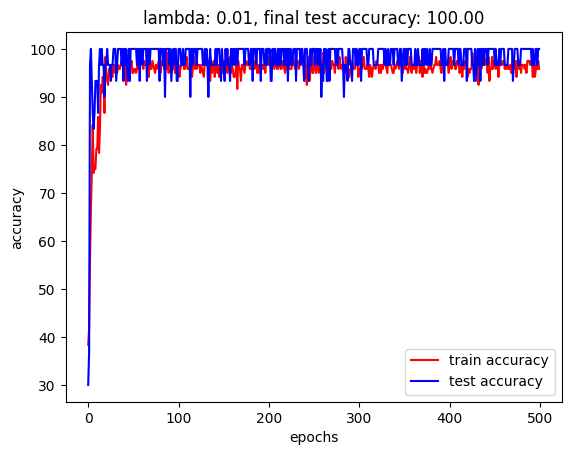

In [6]:
# create and train model
L2Lambda = 0.01
ANNiris, lossFun, optimizer = createModel(L2Lambda)
train_acc, test_acc = training(ANNiris, lossFun, optimizer)

# plot
plt.plot(train_acc, label="train accuracy", color="red")
plt.plot(test_acc, label="test accuracy", color="blue")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title(f"lambda: {L2Lambda}, final test accuracy: {test_acc[-1]:.2f}")
plt.legend()
plt.show()

In [7]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k) / k, mode="same")


# expiriment - varaing lambda from 0 to 0.5 in 25 steps
L2Lambda = np.linspace(0, 0.5, 25)
epochs = 250
final_test_acc = []
train_acc_results = np.zeros((epochs, len(L2Lambda)))
test_acc_results = np.zeros((epochs, len(L2Lambda)))
for i, l2 in enumerate(L2Lambda):
    ANNiris, lossFun, optimizer = createModel(l2)
    train_acc, test_acc = training(ANNiris, lossFun, optimizer, epochs)
    train_acc_results[:, i] = smooth(train_acc, 10)
    test_acc_results[:, i] = smooth(test_acc, 10)
    final_test_acc.append(test_acc[-1])
    print(f"l2: {l2:.2} done")

l2: 0.0 done
l2: 0.021 done
l2: 0.042 done
l2: 0.062 done
l2: 0.083 done
l2: 0.1 done
l2: 0.12 done
l2: 0.15 done
l2: 0.17 done
l2: 0.19 done
l2: 0.21 done
l2: 0.23 done
l2: 0.25 done
l2: 0.27 done
l2: 0.29 done
l2: 0.31 done
l2: 0.33 done
l2: 0.35 done
l2: 0.38 done
l2: 0.4 done
l2: 0.42 done
l2: 0.44 done
l2: 0.46 done
l2: 0.48 done
l2: 0.5 done


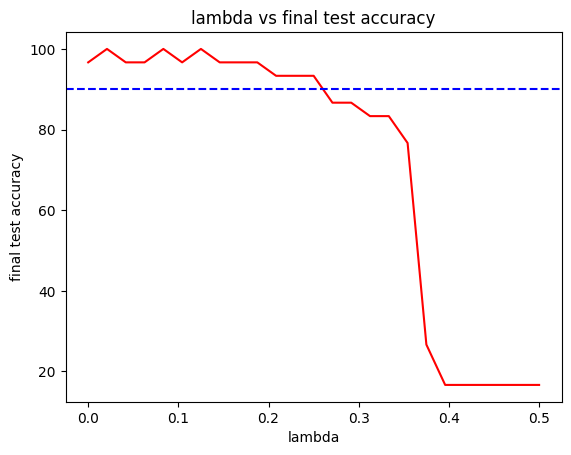

In [8]:
# plot final test accuracy vs lambda
plt.plot(L2Lambda, final_test_acc, color="red")
plt.xlabel("lambda")
plt.ylabel("final test accuracy")
plt.title("lambda vs final test accuracy")
plt.axhline(y=90, color="blue", linestyle="--")
plt.show()

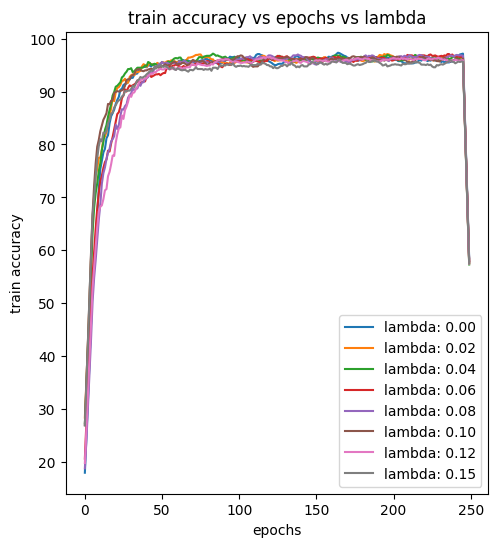

In [9]:
# plot train accuracy vs lambda vs epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, l2 in enumerate(L2Lambda):
    if l2 > 0.15:
        break
    plt.plot(train_acc_results[:, i], label=f"lambda: {l2:.2f}")
plt.xlabel("epochs")
plt.ylabel("train accuracy")
plt.title("train accuracy vs epochs vs lambda")
plt.legend()

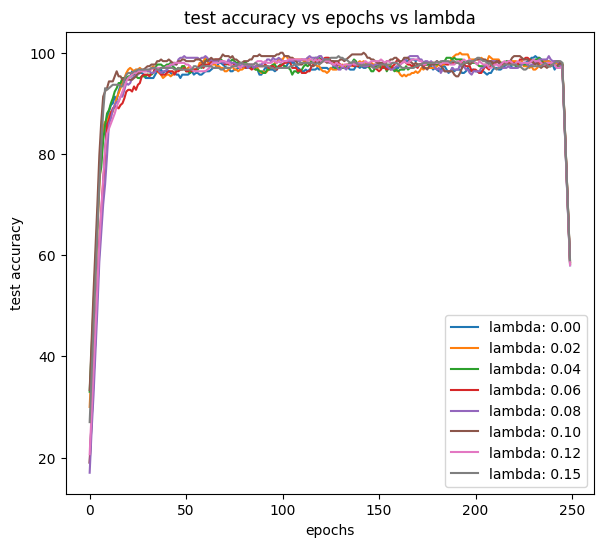

In [14]:
# plot train accuracy vs lambda vs epochs
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 2)
for i, l2 in enumerate(L2Lambda):
    if l2 > 0.15:
        break
    plt.plot(test_acc_results[:, i], label=f"lambda: {l2:.2f}")
plt.xlabel("epochs")
plt.ylabel("test accuracy")
plt.title("test accuracy vs epochs vs lambda")
plt.legend()
plt.show()

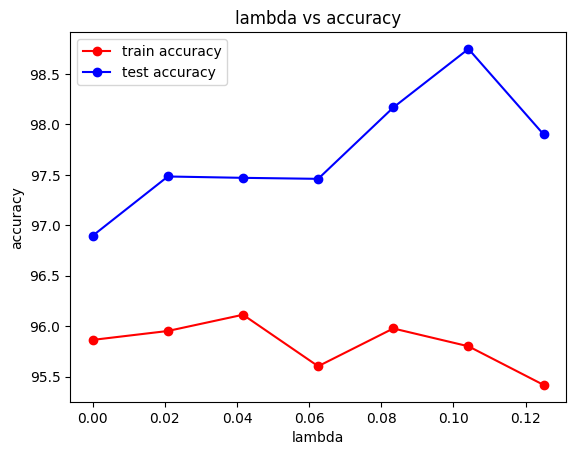

In [11]:
# average train and test accuracy in 50-150 epochs range
noOFLambda = np.where(L2Lambda < 0.15)[0][-1]
epochrange = [50, 150]
train_acc_avg = np.mean(
    train_acc_results[epochrange[0] : epochrange[1], :noOFLambda], axis=0
)
test_acc_avg = np.mean(
    test_acc_results[epochrange[0] : epochrange[1], :noOFLambda], axis=0
)
plt.plot(
    L2Lambda[:noOFLambda],
    train_acc_avg,
    label="train accuracy",
    color="red",
    marker="o",
)
plt.plot(
    L2Lambda[:noOFLambda], test_acc_avg, label="test accuracy", color="blue", marker="o"
)
plt.xlabel("lambda")
plt.ylabel("accuracy")
plt.title("lambda vs accuracy")
plt.legend()
plt.show()